In [2]:
from datasets import load_dataset

ds = load_dataset("13nishit/LoanApprovalPrediction")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/614 [00:00<?, ? examples/s]

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame(ds['train'])
print(df.shape)
df.head()


(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Loan_Status
Y    422
N    192
Name: count, dtype: int64
Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
Loan_ID               0
CoapplicantIncome     0
ApplicantIncome       0
Property_Area         0
Loan_Status           0
dtype: int64


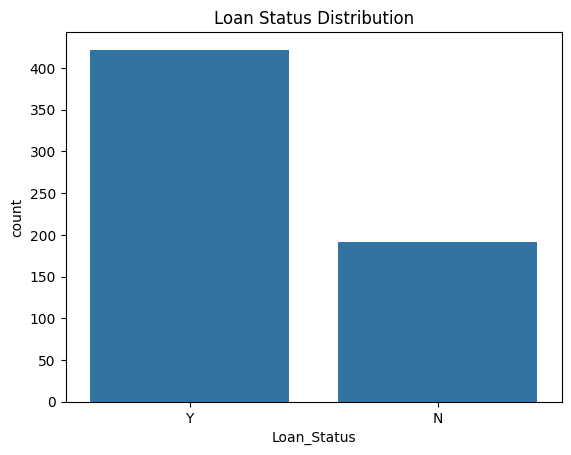

In [5]:
# Check class distribution
print(df['Loan_Status'].value_counts())

# Missing values
print(df.isnull().sum().sort_values(ascending=False))

# Plot class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Loan_Status', data=df)
plt.title("Loan Status Distribution")
plt.show()


In [6]:
# Map target: Y=1, N=0
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})


In [7]:
# Fill numerical columns with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [8]:
df = pd.get_dummies(df, drop_first=True)


In [9]:
df.shape

(614, 628)

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(['Loan_Status', 'Loan_ID'], axis=1, errors='ignore')
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from imblearn.over_sampling import SMOTE

# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)



🔹 Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.63      0.75        38
           1       0.86      0.98      0.91        85

    accuracy                           0.87       123
   macro avg       0.89      0.80      0.83       123
weighted avg       0.88      0.87      0.86       123

Accuracy: 0.8699186991869918
ROC AUC: 0.8529411764705882


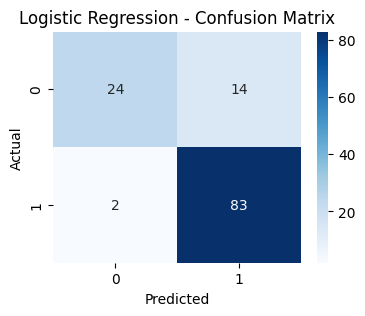


🔹 Random Forest
              precision    recall  f1-score   support

           0       0.91      0.55      0.69        38
           1       0.83      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.87      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123

Accuracy: 0.8455284552845529
ROC AUC: 0.7888544891640867


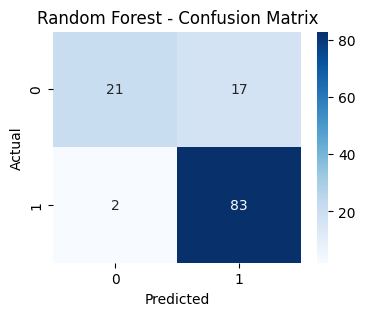


🔹 XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:04:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.62      0.63      0.62        38
           1       0.83      0.82      0.83        85

    accuracy                           0.76       123
   macro avg       0.72      0.73      0.73       123
weighted avg       0.77      0.76      0.77       123

Accuracy: 0.7642276422764228
ROC AUC: 0.7712074303405573


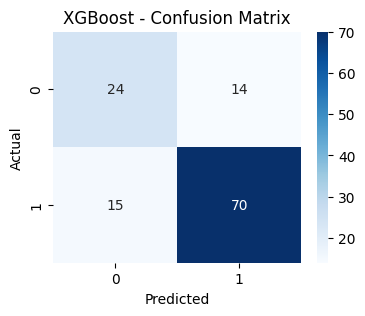

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n🔹 {name}")

    # Use scaled data only for Logistic Regression
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        probas = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probas = model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, probas))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


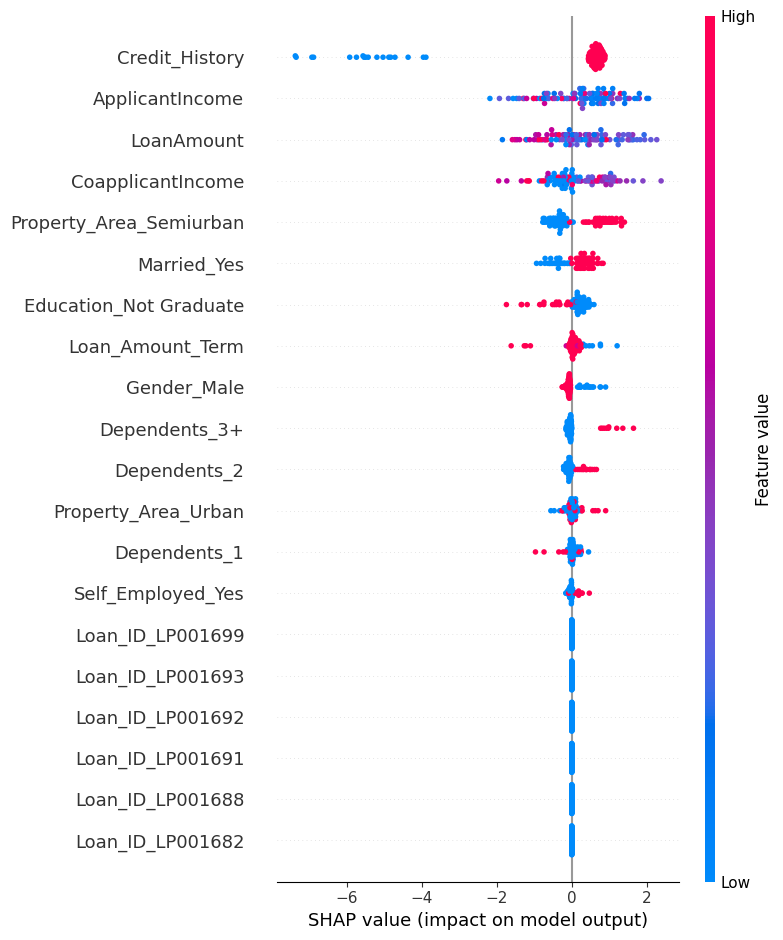

In [14]:
import shap

# Choose best model (e.g., XGBoost)
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test[:100])  # sample

# Plot feature importance
shap.summary_plot(shap_values, X_test[:100])


In [ ]:
import joblib
import pandas as pd
import numpy as np

model = joblib.load("loan_approval_final_pipeline.pkl")

sample = {
    'Gender': ['Male'],
    'Married': ['Yes'],
    'Dependents': ['0'],
    'Education': ['Graduate'],
    'Self_Employed': ['No'],
    'ApplicantIncome': [5000],
    'CoapplicantIncome': [2000],
    'LoanAmount': [100],
    'Loan_Amount_Term': [360],
    'Credit_History': [1.0],
    'Property_Area': ['Urban']
}

df = pd.DataFrame(sample)
print("Predicted:", model.predict(df))
print("Probabilities:", model.predict_proba(df))
